# 2. Single-Scale Lucas-Kanade Optical Flow
## 2.1. Keypoint Selection: Selecting Pixels to Track
Use OpenCV’s goodFeaturesToTrack function with the useHarrisDetector flag set as True and visualize the feature points obtained by the algorithm. Visualize the detected pixels superimposed on the images for at least one image from each of the given sequences.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def feature_detector(img, flag):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the top 100 corners using the cv2.goodFeaturesToTrack()
    features = cv2.goodFeaturesToTrack(gray, 100,0.01,10, useHarrisDetector=True)
    features = np.int0(features)

    # Iterate over the corners and draw a circle at that location
    for i in features:
        x,y = i.ravel()
        cv2.circle(img,(x,y),3,(0,0,255),-1)
        
    # Save the image
    if(flag==0):
        cv2.imwrite("../results/1_key_point_selection/grove_corner.jpg", img)
    elif(flag==1):
        cv2.imwrite("../results/1_key_point_selection/rubberwhale_corner.jpg", img)
    elif(flag==2):
        cv2.imwrite("../results/1_key_point_selection/urban_corner.jpg", img)
    else:
        pass
    return img

/var/folders/jc/33x9x29n3sd6wvf98brkm9hh0000gn/T/ipykernel_4178/1642282401.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  features = np.int0(features)


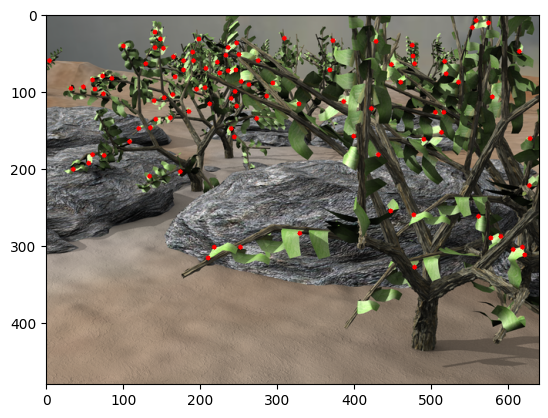

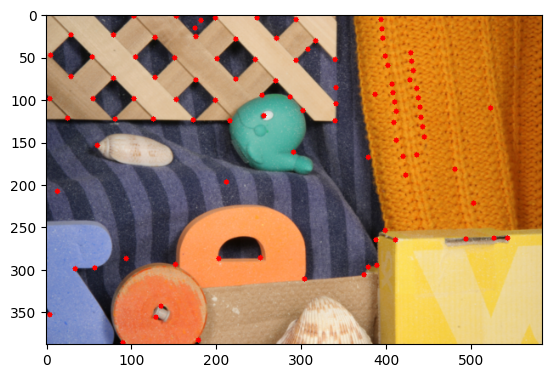

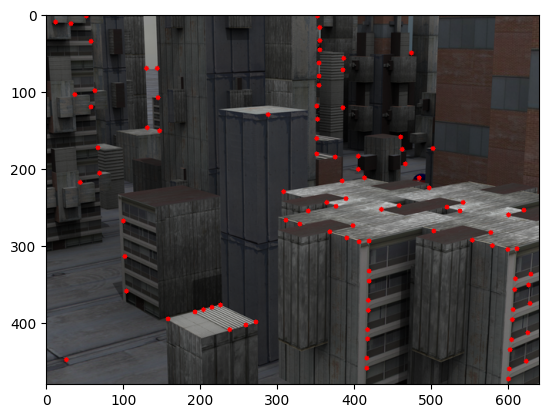

In [3]:
img1 = cv2.imread("../data/all-frames-colour/Grove3/frame07.png")
img2 = cv2.imread("../data/all-frames-colour/RubberWhale/frame07.png")
img3 = cv2.imread("../data/all-frames-colour/Urban2/frame07.png")

for flag, img in enumerate([img1, img2, img3]):
    superimposed_img = feature_detector(img, flag)
    plt_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(plt_img)
    plt.show()

## 2.2. Forward-Additive Sparse Optical Flow

### 1. Visualizing the dense optical flow of the .flo files given (use the helper code of this)

In [4]:
# Helper Code

UNKNOWN_FLOW_THRESH = 1e7
def show_flow(filename):
    """
    visualize optical flow map using matplotlib
    :param filename: optical flow file
    :return: None
    """
    flow = read_flow(filename)
    img, _, _ = flow_to_image(flow)
    plt.imshow(img)
    plt.show()

def read_flow(filename):
    """
    read optical flow from Middlebury .flo file
    :param filename: name of the flow file
    :return: optical flow data in matrix
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print ('Magic number incorrect. Invalid .flo file')
    else:
        w = int(np.fromfile(f, np.int32, count=1)[0])
        h = int(np.fromfile(f, np.int32, count=1)[0])
        #print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img), u, v


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

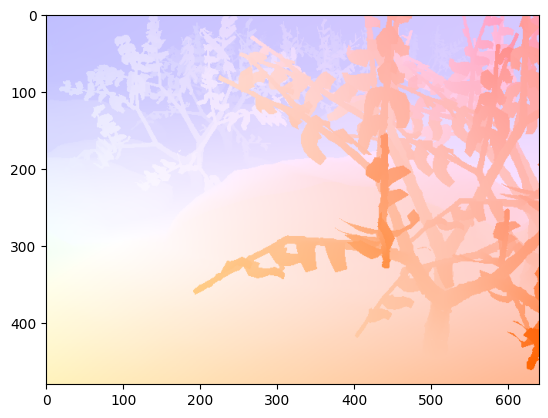

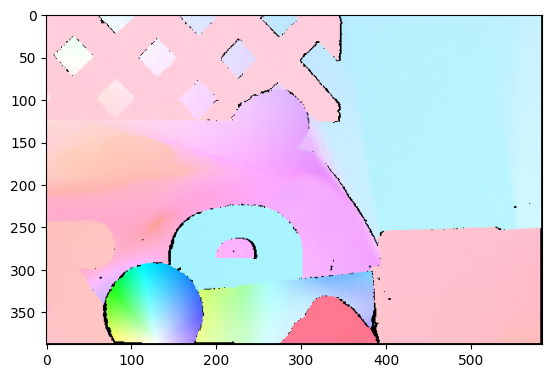

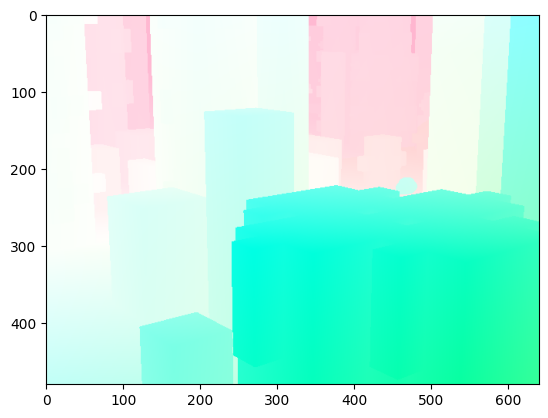

In [5]:
show_flow("../data/ground-truth-flow/Grove3/flow10.flo")
show_flow("../data/ground-truth-flow/RubberWhale/flow10.flo")
show_flow("../data/ground-truth-flow/Urban2/flow10.flo")

### 2. Implement sparse LK Method

Explanation:

The function LucasKanadeForwardAdditive(Img1, Img2, windowSize, tau) takes two consecutive frames as input and returns the optical flow vectors u and v. <br />
The function performs the floowing steps: <br />
- First, the cv2.goodFeaturesToTrack feature detector is used to find the corner features in Img1 frame. <br />
- Next, the single-scale Lucas-Kanade method is implemented to track the corner features in the Img2 frame. <br />
- For each corner feature, a window of size 1x2 is extracted from both the frames. <br />
- The optical flow between the two windows is computed by solving the least squares problem, where the flow vector is represented as flow = [u, v] and A and B are computed from the two windows. <br />

In [6]:
# sparse LK method only on detected features

from scipy import signal

def plot_optical_flow(img, u, v, gran=6):
    '''
    Plotting Quiver Plot to show Optical Flow
    '''
    flow_map = np.zeros(u.shape)

    for y in range(flow_map.shape[0]):
        for x in range(flow_map.shape[1]):
        
            dx = int(50 * u[y, x])
            dy = int(50 * v[y, x])
            
            # if dx!=0:
            #     print("u[y, x]", u[y, x])
            # if dy!=0:
            #     print("v[y, x]", v[y, x])

            if dx > 0 or dy > 0:
                img = cv2.arrowedLine(img, (x, y), (x + dx, y + dy), 255, 1)
                
    return img

def LucasKanadeForwardAdditive(Img1, Img2, windowSize=10, tau=0.01, ret_xy = False):
    '''
    This function performs single-scale LK optical flow estimation between two images.
    
    Arguments: 
        Img1: First Image
        Img2: Second Image
        windowSize: window block NxN
        tau: threshold; if tau is larger than the smallest eigenvalue of (A_transpose . A), optical flow at that position should not be computed
        ret_xy: position of the detected features
    
    Returns:
        u: u-component of optical flow for each feature point
        v: v-component of optical flow for each feature point
    '''
    
    # Images are converted to grayscale
    gray1 = Img1
    gray2 = Img2

    # map intensity value to the range [0,1]
    gray1 = gray1 / 255
    gray2 = gray2 / 255

    image_shape = gray1.shape
    half_window_size = windowSize // 2

    # define convolution kernels to later compute spatial (x, y) and temporal (t) gradients of intensity.
    conv_filter_x = np.array([[-1., 1.], [-1., 1.]])
    conv_filter_y = np.array([[-1., -1.], [1., 1.]])
    conv_filter_t = np.array([[1., 1.], [1., 1.]]) / 2

    mode = "same"
    # for each point in the small window region, compute Ix, Iy, It i.e., intensity gradients.
    # Derivative of Intensity in X direction
    Ix = signal.convolve2d(gray1, conv_filter_x, boundary='symm', mode=mode)
    # Derivative of Intensity in Y direction
    Iy = signal.convolve2d(gray1, conv_filter_y, boundary='symm', mode=mode)
    # Derivative of Intensity wrt t
    It = signal.convolve2d(gray2, conv_filter_t, boundary='symm', mode=mode) + signal.convolve2d(gray1, -conv_filter_t, boundary='symm', mode=mode)

    # Initializing u and v vectors
    u = np.zeros(image_shape)
    v = np.zeros(image_shape)
    
    xy_pos = []
    features = cv2.goodFeaturesToTrack(gray1.astype(np.float32), 100,0.01,20, useHarrisDetector=True)
    # features = np.int(features)
        
    for feature in features: 
        y, x = feature.ravel() # for every corner feature, get cordinates of the corners (x,y). They are stored in the order y, x
        x, y = int(x), int(y)
        
        # if ((x + half_window_size) < image_shape[1] or (y + half_window_size) < image_shape[0]):
        Ix_windowed = Ix[
            x - half_window_size : x + half_window_size + 1, 
            y - half_window_size : y + half_window_size + 1
        ].flatten()
        Iy_windowed = Iy[
            x - half_window_size : x + half_window_size + 1, 
            y - half_window_size : y + half_window_size + 1
        ].flatten()
        It_windowed = It[
            x - half_window_size : x + half_window_size + 1, 
            y - half_window_size : y + half_window_size + 1
        ].flatten()
            
        
        ''' 
        1. Linear system of equations of the form -> Au = B 
        2. To solve this linear system, Multiply both sides by A_transpose -> A_T . Au = A_T . B
        3. => u = inv(A_transpose . A) . A_transpose . B
        '''
        
        A = []
        for m, n in zip(Ix_windowed, Iy_windowed):
            A.append([m,n])
        A = np.asarray(A).reshape(-1, 2)
        
        # A = np.asarray([Ix_windowed, Iy_windowed]).reshape(-1, 2)
        # B = np.asarray(It_windowed)
        B = np.reshape(It_windowed, (It_windowed.shape[0],1))
        
        A_transpose_A = np.dot(np.transpose(A), A)
        A_transpose_A_eig_vals, _ = np.linalg.eig(A_transpose_A)
        A_transpose_A_min_eig_val = np.min(A_transpose_A_eig_vals)

        # if threshold τ is larger than the smallest eigenvalue of A'A, don't compute optical flow:
        if A_transpose_A_min_eig_val < tau:
            continue

        A_transpose_A_PINV = np.linalg.pinv(A_transpose_A)
        
        # vectors with minimized square error
        close_fit_u = A_transpose_A_PINV @ np.transpose(A) @ B
        
        # print(close_fit_u[0])

        u[x, y]=close_fit_u[0]
        v[x, y]=close_fit_u[1]
        xy_pos.append([x,y])
    
    # print("np.nonzero(u)", np.nonzero(u))
    print("u", u.shape)
    print("v", v.shape)
    if ret_xy == False:
        return u, v
    else:
        return u, v, xy_pos

u (388, 584)
v (388, 584)


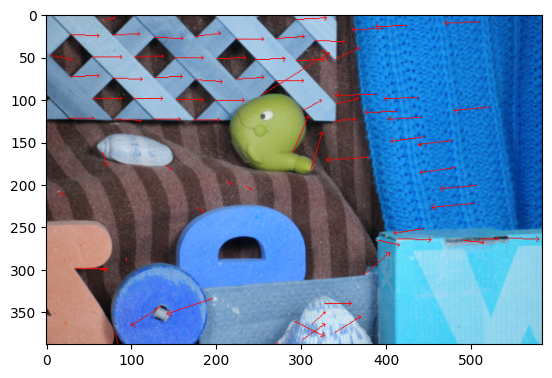

In [7]:
# Reading in the set of images
whale1 = cv2.imread('../data/all-frames-colour/RubberWhale/frame07.png')
whale2 = cv2.imread('../data/all-frames-colour/RubberWhale/frame08.png')

gray1 = cv2.cvtColor(whale1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(whale2, cv2.COLOR_RGB2GRAY)
u, v = LucasKanadeForwardAdditive(gray1, gray2)

img = plot_optical_flow(whale1, u, v, gran=6)
plt.imshow(img)
plt.show()

### 3. Plotting and comparing your implementation and OpenCV implementation for all consecutive frames for the three sequences. You have to add quiver plots superimpose on the images. (OpenCV implementation uses multi-scale LK so It is alright if the results are not the same, but the general flow will still be the same)

#### Comparison of my implementation with OpenCV implementation for all consecutive frames for the three sequences. 

#### OpenCV implementation for aforementioned example

In [8]:
import numpy as np
import cv2

def optical_flow_opencv(Img1, Img2):
    # params for corner detection
    feature_params = dict( maxCorners = 100,
                        qualityLevel = 0.2,
                        minDistance = 7,
                        blockSize = 7)

    # Parameters for lucas kanade optical flow
    lk_params = dict(winSize = (15, 15),
                    maxLevel = 3)

    # Take first frame and find corners in it
    Img1_gray = cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(Img1_gray, mask = None, **feature_params)

    Img2_gray = cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(Img1_gray,
                                        Img2_gray,
                                        p0, None,
                                        **lk_params)

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = old.ravel() # tail of arrow (initial point)
        c, d = new.ravel()
        e, f = c-a, d-b # distance between initian and final point
        e, f = 30*e, 30*f # amplifying distance so that optical flow arrow is visible on the frame
        c, d = a+e, b+f # head of arrow (final point)

        img = cv2.arrowedLine(Img1, (int(a), int(b)), (int(c), int(d)), 255, 1)

    return img

#### My Implementation vs OpenCV implementation for all sequences

In [9]:
import os

def my_vs_cv_LK(dir_path, flag):
    ''' 
    This function accepts a directory that contains a sequence of images.
    One two consecutive images, optical flow is performed, 
    via my LK implementation and OpenCV's LK implementation as well.
    Comparison frames are shown as well as saved in the results directory.
    '''
    img_list = os.listdir(dir_path)
    img_list.sort()
    print(img_list)

    frame_num = 0
    for img in img_list:
        if frame_num < len(img_list)-1:
            img_path_1 = dir_path + img_list[frame_num]
            img_path_2 = dir_path + img_list[frame_num + 1]
            print("img_path_1", img_path_1)
            print("img_path_2", img_path_2)

            Img1 = cv2.imread(img_path_1)
            Img2 = cv2.imread(img_path_2)
            Img1_gray = cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY)
            Img2_gray = cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY)
            
            Img1_ = cv2.imread(img_path_1)
            Img2_ = cv2.imread(img_path_2)
            
            # my implementation of single-scale lucas-kanade
            u, v = LucasKanadeForwardAdditive(Img1_gray, Img2_gray)
            if flag == 1: # Grove3
                gran = 18
            elif flag == 2: # RubberWhale
                gran = 6
            else: # Urban2
                gran = 12
            plot_img_my = plot_optical_flow(Img1, u, v, gran)

            # opencv implementation of lucas-kanade
            plot_img_cv = optical_flow_opencv(Img1_, Img2_)

            # Plot Image
            # create figure
            fig = plt.figure(figsize=(10, 7))
        
            # setting values to rows and column variables
            rows = 1
            columns = 2

            # Adds a subplot at the 1st position
            fig.add_subplot(rows, columns, 1)

            # showing image
            plt.imshow(plot_img_my)
            plt.axis('off')
            plt.title("My LK implementation \n" + str(img_list[frame_num]))

            # Adds a subplot at the 2nd position
            fig.add_subplot(rows, columns, 2)

            # showing image
            plt.imshow(plot_img_cv)
            plt.axis('off')
            plt.title("OpenCV implementation \n" + str(img_list[frame_num]))

            plt.show()
            
            # saving images
            if flag==1: # Grove3
                plt.imsave("../results/2_optical_flow_my/Grove3/" + str(img_list[frame_num]), plot_img_my)
                plt.imsave("../results/2_optical_flow_opencv/Grove3/" + str(img_list[frame_num]), plot_img_cv)

            elif flag==2: # RubberWhale
                plt.imsave("../results/2_optical_flow_my/RubberWhale/" + str(img_list[frame_num]), plot_img_my)
                plt.imsave("../results/2_optical_flow_opencv/RubberWhale/" + str(img_list[frame_num]), plot_img_cv)

            else: # Urban2
                plt.imsave("../results/2_optical_flow_my/Urban2/" + str(img_list[frame_num]), plot_img_my)
                plt.imsave("../results/2_optical_flow_opencv/Urban2/" + str(img_list[frame_num]), plot_img_cv)

            frame_num += 1

#### My Implementation vs OpenCV implementation for all sequences of Grove3

['frame07.png', 'frame08.png', 'frame09.png', 'frame10.png', 'frame11.png', 'frame12.png', 'frame13.png', 'frame14.png']
img_path_1 ../data/all-frames-colour/Grove3/frame07.png
img_path_2 ../data/all-frames-colour/Grove3/frame08.png
u (480, 640)
v (480, 640)


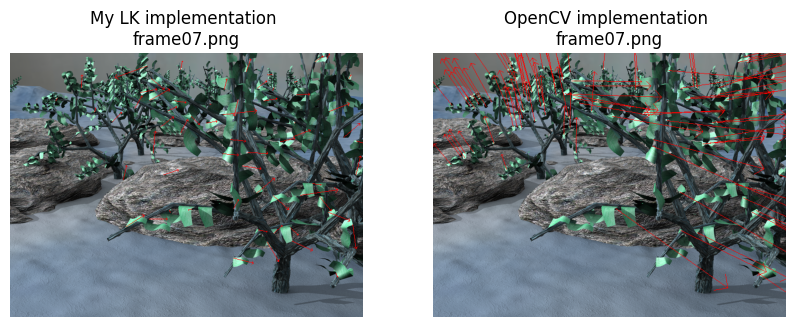

img_path_1 ../data/all-frames-colour/Grove3/frame08.png
img_path_2 ../data/all-frames-colour/Grove3/frame09.png
u (480, 640)
v (480, 640)


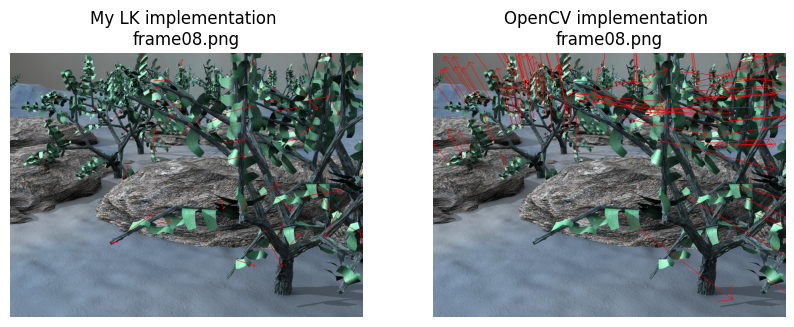

img_path_1 ../data/all-frames-colour/Grove3/frame09.png
img_path_2 ../data/all-frames-colour/Grove3/frame10.png
u (480, 640)
v (480, 640)


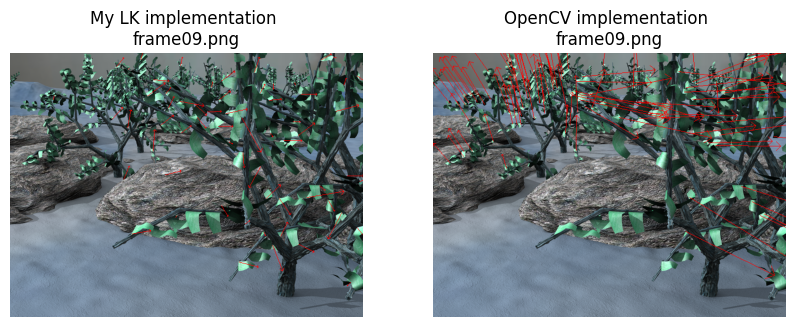

img_path_1 ../data/all-frames-colour/Grove3/frame10.png
img_path_2 ../data/all-frames-colour/Grove3/frame11.png
u (480, 640)
v (480, 640)


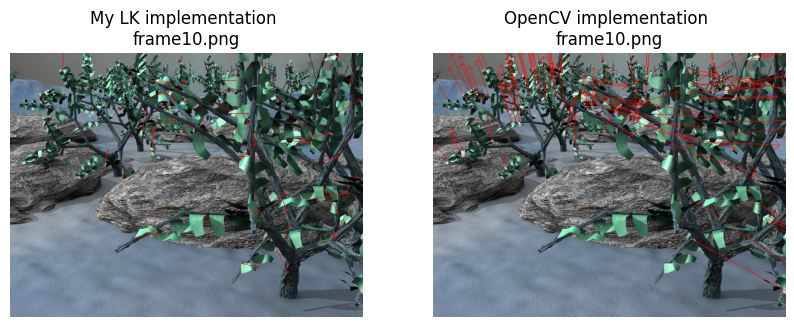

img_path_1 ../data/all-frames-colour/Grove3/frame11.png
img_path_2 ../data/all-frames-colour/Grove3/frame12.png
u (480, 640)
v (480, 640)


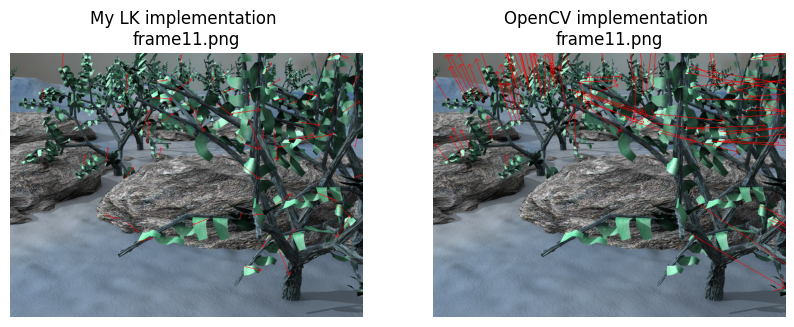

img_path_1 ../data/all-frames-colour/Grove3/frame12.png
img_path_2 ../data/all-frames-colour/Grove3/frame13.png
u (480, 640)
v (480, 640)


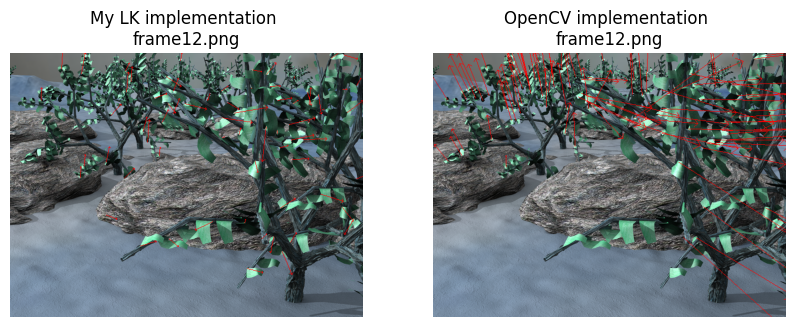

img_path_1 ../data/all-frames-colour/Grove3/frame13.png
img_path_2 ../data/all-frames-colour/Grove3/frame14.png
u (480, 640)
v (480, 640)


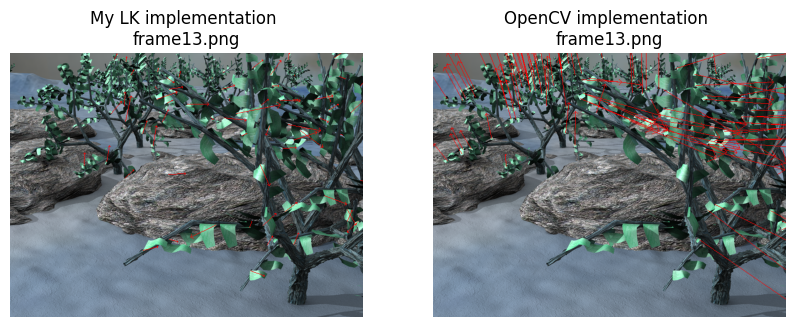

In [10]:
my_vs_cv_LK("../data/all-frames-colour/Grove3/", flag=1)

#### My Implementation vs OpenCV implementation for all sequences of RubberWhale

['frame07.png', 'frame08.png', 'frame09.png', 'frame10.png', 'frame11.png', 'frame12.png', 'frame13.png', 'frame14.png']
img_path_1 ../data/all-frames-colour/RubberWhale/frame07.png
img_path_2 ../data/all-frames-colour/RubberWhale/frame08.png
u (388, 584)
v (388, 584)


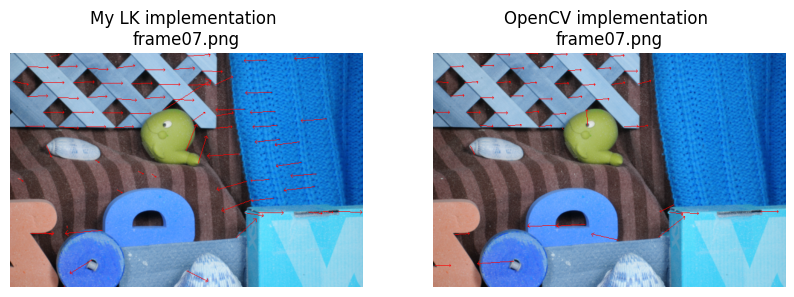

img_path_1 ../data/all-frames-colour/RubberWhale/frame08.png
img_path_2 ../data/all-frames-colour/RubberWhale/frame09.png
u (388, 584)
v (388, 584)


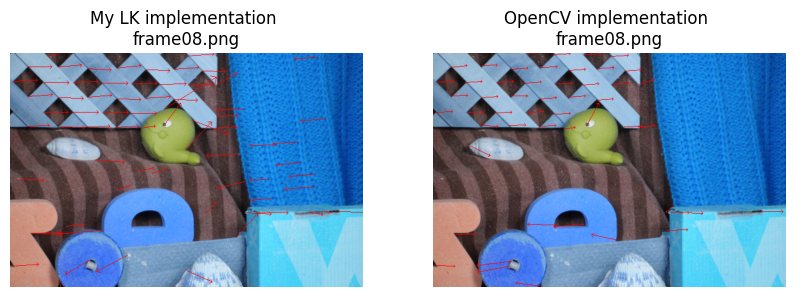

img_path_1 ../data/all-frames-colour/RubberWhale/frame09.png
img_path_2 ../data/all-frames-colour/RubberWhale/frame10.png
u (388, 584)
v (388, 584)


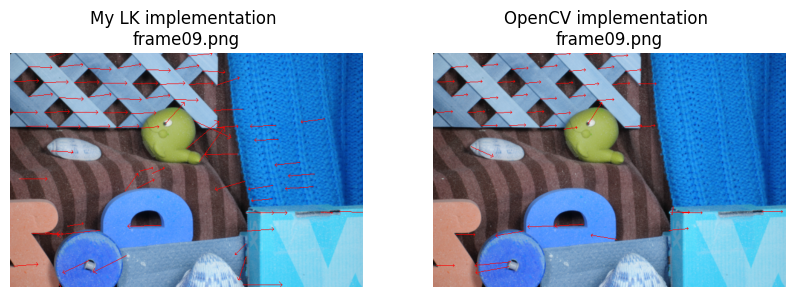

img_path_1 ../data/all-frames-colour/RubberWhale/frame10.png
img_path_2 ../data/all-frames-colour/RubberWhale/frame11.png
u (388, 584)
v (388, 584)


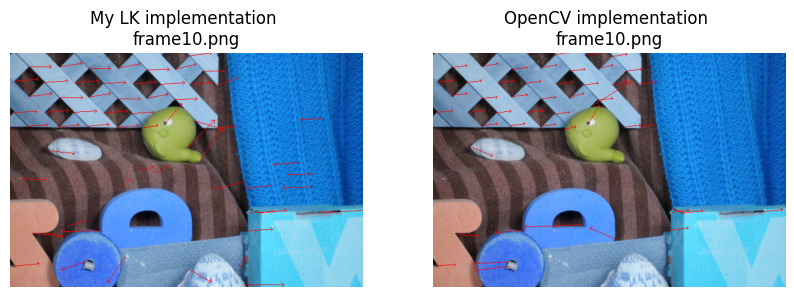

img_path_1 ../data/all-frames-colour/RubberWhale/frame11.png
img_path_2 ../data/all-frames-colour/RubberWhale/frame12.png
u (388, 584)
v (388, 584)


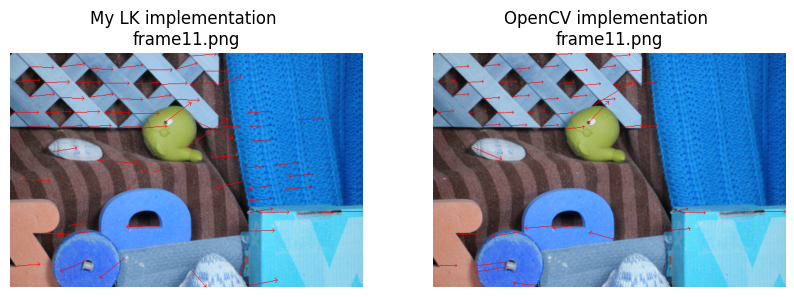

img_path_1 ../data/all-frames-colour/RubberWhale/frame12.png
img_path_2 ../data/all-frames-colour/RubberWhale/frame13.png
u (388, 584)
v (388, 584)


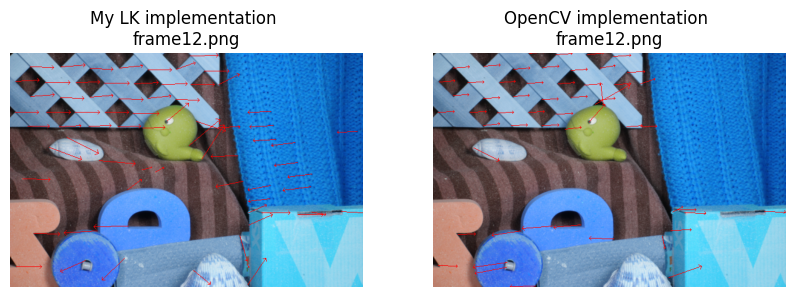

img_path_1 ../data/all-frames-colour/RubberWhale/frame13.png
img_path_2 ../data/all-frames-colour/RubberWhale/frame14.png
u (388, 584)
v (388, 584)


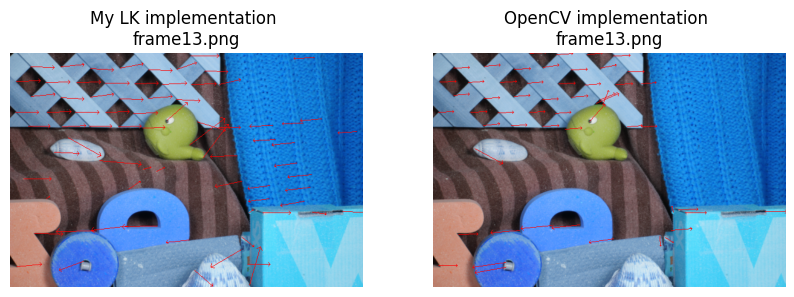

In [11]:
my_vs_cv_LK("../data/all-frames-colour/RubberWhale/", flag=2)

#### My Implementation vs OpenCV implementation for all sequences of Urban2

['frame07.png', 'frame08.png', 'frame09.png', 'frame10.png', 'frame11.png', 'frame12.png', 'frame13.png', 'frame14.png']
img_path_1 ../data/all-frames-colour/Urban2/frame07.png
img_path_2 ../data/all-frames-colour/Urban2/frame08.png
u (480, 640)
v (480, 640)


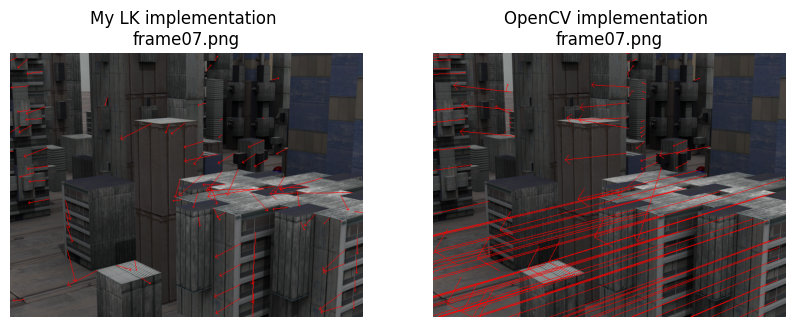

img_path_1 ../data/all-frames-colour/Urban2/frame08.png
img_path_2 ../data/all-frames-colour/Urban2/frame09.png
u (480, 640)
v (480, 640)


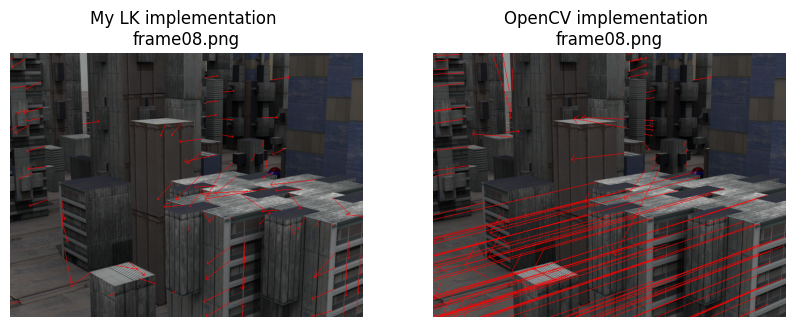

img_path_1 ../data/all-frames-colour/Urban2/frame09.png
img_path_2 ../data/all-frames-colour/Urban2/frame10.png
u (480, 640)
v (480, 640)


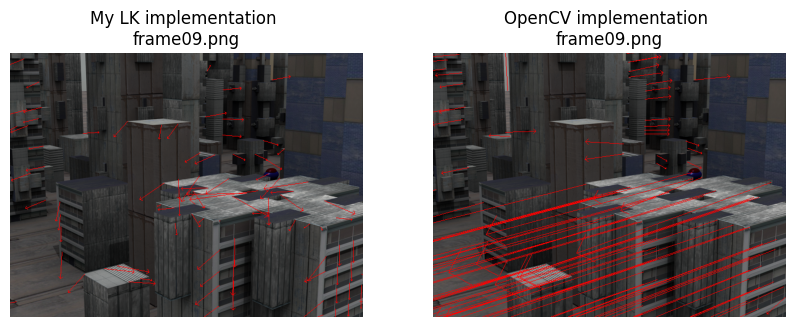

img_path_1 ../data/all-frames-colour/Urban2/frame10.png
img_path_2 ../data/all-frames-colour/Urban2/frame11.png
u (480, 640)
v (480, 640)


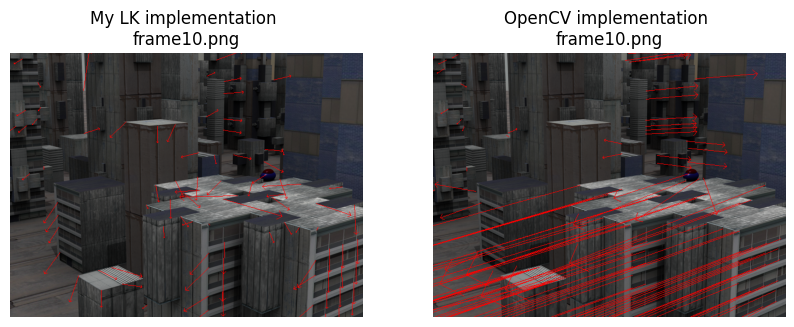

img_path_1 ../data/all-frames-colour/Urban2/frame11.png
img_path_2 ../data/all-frames-colour/Urban2/frame12.png
u (480, 640)
v (480, 640)


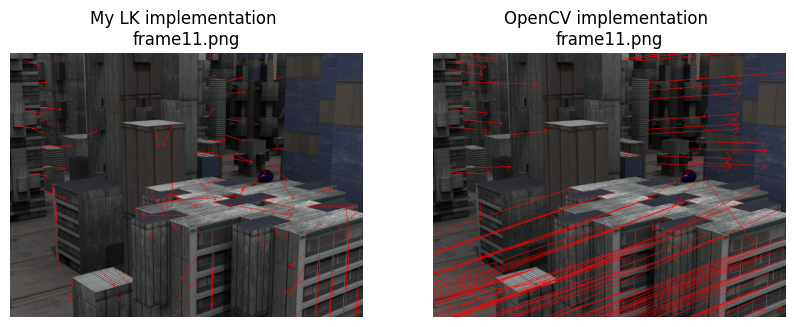

img_path_1 ../data/all-frames-colour/Urban2/frame12.png
img_path_2 ../data/all-frames-colour/Urban2/frame13.png
u (480, 640)
v (480, 640)


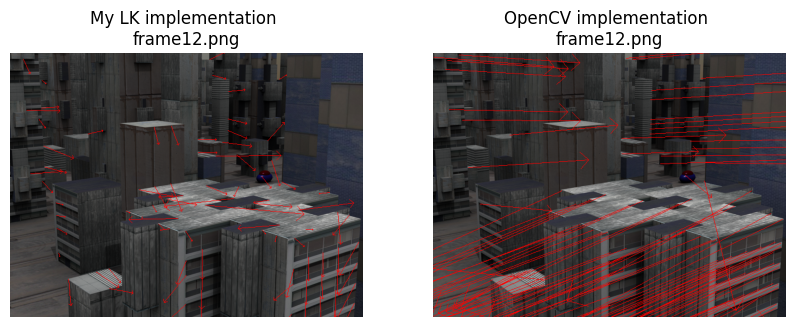

img_path_1 ../data/all-frames-colour/Urban2/frame13.png
img_path_2 ../data/all-frames-colour/Urban2/frame14.png
u (480, 640)
v (480, 640)


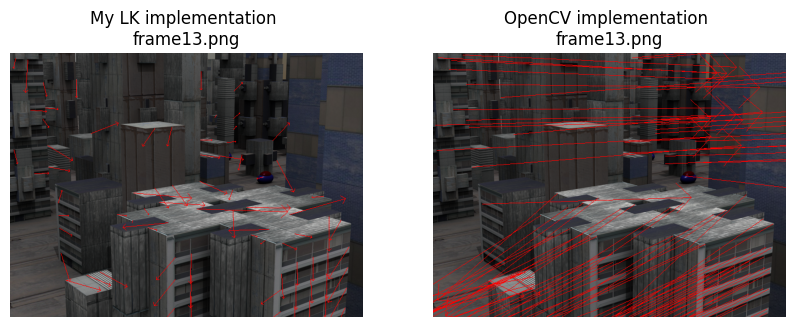

In [12]:
my_vs_cv_LK("../data/all-frames-colour/Urban2/", flag=3)

### 4. Create a video out of the images to show the optical flow (This is an optional task, it helps you to see if the optical flow vectors are in line with the actual motion of the images)

In [13]:

def merge_images_to_video(frame_folder, output_video_path, frame_rate):
    '''
      This function responsible to read frames sequentially from the folder and then writing those frames to a video.
      
      Input:
        frame_folder: This is the folder that contains the image frames.
        output_video_path: This is the path of our output video that we want to create by merging the frames residing in the "frame_folder".
        frame_rate: This is the frame rate (FPS) of our output video.
    '''
    
    frames_list = [] # this will store the list of numpy array (frames), to be converted to video
    
    files = os.listdir(frame_folder)
    files.sort()
    print(files) # Here, you'll see that files are arranged in the list in the ascending order of the number sequence. This is particularly important for smooth rendering of the video.

    for i in range(len(files)):
        filename = frame_folder+files[i] # Get frame-path from the 'files' list one by one
        img = cv2.imread(filename) # Read frame from that frame-path
        height, width, _ = img.shape # Get, height and width of that frame which we just read
        size = (width, height) # create a 'size' tuple which stores width and height
        frames_list.append(img) # append this image (numpy array) in the list 'frames_list'
    
    '''
    Here, a video writer object is created named 'out_vid' using a method of cv2 library, VidWriter() that accepts following arguments:
      output_video_path: Here, I named the output file that I want after merging all the frames.
      fourcc: Here, I have to mention the codec format to compress our frames. I have chosen MJPEG (motion jpeg) video compression format.
      size: Here, the size of the frame that we have chosen is default frame size that we extract via img.shape.
    '''
    out_vid = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'MJPG'), frame_rate, size)
    for i in range(len(frames_list)):
        out_vid.write(frames_list[i])
    print(f"Successfully created Video! {output_video_path}")
    out_vid.release()

In [14]:
frame_folder = "../results/2_optical_flow_my/Grove3/"
output_video_path = '../results/2_optical_flow_my/' + 'output_Grove3.avi'
frame_rate = 5 # You can change this number to any other number to control the FPS (frames per second) of the output video.
merge_images_to_video(frame_folder, output_video_path, frame_rate)

['frame07.png', 'frame08.png', 'frame09.png', 'frame10.png', 'frame11.png', 'frame12.png', 'frame13.png']
Successfully created Video! ../results/2_optical_flow_my/output_Grove3.avi


In [15]:
frame_folder = "../results/2_optical_flow_my/RubberWhale/"
output_video_path = '../results/2_optical_flow_my/' + 'output_RubberWhale.avi'
frame_rate = 5
merge_images_to_video(frame_folder, output_video_path, frame_rate)

['frame07.png', 'frame08.png', 'frame09.png', 'frame10.png', 'frame11.png', 'frame12.png', 'frame13.png']
Successfully created Video! ../results/2_optical_flow_my/output_RubberWhale.avi


In [16]:
frame_folder = "../results/2_optical_flow_my/Urban2/"
output_video_path = '../results/2_optical_flow_my/' + 'output_Urban2.avi'
frame_rate = 5
merge_images_to_video(frame_folder, output_video_path, frame_rate)

['frame07.png', 'frame08.png', 'frame09.png', 'frame10.png', 'frame11.png', 'frame12.png', 'frame13.png']
Successfully created Video! ../results/2_optical_flow_my/output_Urban2.avi


### 5. Compute the Average End Point Error (EPE) between the ground truth optical flow in .flo files and your predicted optical flow (only for the feature points detect.

The Average End Point Error (EPE) is a measure of the error between the ground truth optical flow and the predicted optical flow. It is calculated as the average of the Euclidean distances between the end points of the optical flow vectors in the ground truth and predicted flow maps.

In [17]:
def avg_endpoint_error(u_gt, v_gt, u_pred, v_pred, xy_pos):
    """
    Calculate average endpoint error between ground-truth and predicted optical flow
    
    Arguments:
        u_gt: 2D ground-truth u vector, shape (height, width)
        v_gt: 2D ground-truth v vector, shape (height, width)
        u_pred: 2D predicted u vector, shape (height, width)
        v_pred: 2D predicted v vector, shape (height, width)
        xy_pos: x,y coordinates of our features
    Return: 
        average endpoint error
    """
    
    errors = list()
    for a,b in xy_pos :
        errors.append(np.sqrt((u_gt[a,b] - u_pred[a,b])**2 + (v_gt[a,b] - v_pred[a,b])**2))
    
    return np.mean(errors)

#### Average EPE between Ground-truth and Predicted flow values - Grove3

In [18]:
# Read flow vectors from ground-truth .flo file of Grove3
flow = read_flow("../data/ground-truth-flow/Grove3/flow10.flo")
_, u_gt, v_gt = flow_to_image(flow)

# Read flow vectors by computing optical flow between frames 10 and 11
Img1 = cv2.imread('../data/all-frames-colour/Grove3/frame10.png')
Img2 = cv2.imread('../data/all-frames-colour/Grove3/frame11.png')
Img1 = cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY)
Img2 = cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY)
u_pred, v_pred, xy_pos = LucasKanadeForwardAdditive(Img1, Img2, 10, 0.01, True)

# print(u_gt.shape, u_pred.shape)
# print("xy_pos ", xy_pos)

# Calculate average endpoint error
aepe = avg_endpoint_error(u_gt, v_gt, u_pred, v_pred, xy_pos)
print("avg_endpoint_error: ", aepe)

u (480, 640)
v (480, 640)
avg_endpoint_error:  0.4449779303660617


#### Average EPE between Ground-truth and Predicted flow values - RubberWhale

In [19]:
# Read flow vectors from ground-truth .flo file of RubberWhale
flow = read_flow("../data/ground-truth-flow/RubberWhale/flow10.flo")
_, u_gt, v_gt = flow_to_image(flow)

# Read flow vectors by computing optical flow between frames 10 and 11
Img1 = cv2.imread('../data/all-frames-colour/RubberWhale/frame10.png')
Img2 = cv2.imread('../data/all-frames-colour/RubberWhale/frame11.png')
Img1 = cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY)
Img2 = cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY)
u_pred, v_pred, xy_pos = LucasKanadeForwardAdditive(Img1, Img2, 10, 0.01, True)

# Calculate average endpoint error
aepe = avg_endpoint_error(u_gt, v_gt, u_pred, v_pred, xy_pos)
print("avg_endpoint_error: ", aepe)

u (388, 584)
v (388, 584)
avg_endpoint_error:  0.5826030005026356


#### Average EPE between Ground-truth and Predicted flow values - Urban2

In [20]:
# Read flow vectors from ground-truth .flo file of Urban2
flow = read_flow("../data/ground-truth-flow/Urban2/flow10.flo")
_, u_gt, v_gt = flow_to_image(flow)

# Read flow vectors by computing optical flow between frames 10 and 11
Img1 = cv2.imread('../data/all-frames-colour/Urban2/frame10.png')
Img2 = cv2.imread('../data/all-frames-colour/Urban2/frame11.png')
Img1 = cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY)
Img2 = cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY)
u_pred, v_pred, xy_pos = LucasKanadeForwardAdditive(Img1, Img2, 10, 0.01, True)

# Calculate average endpoint error
aepe = avg_endpoint_error(u_gt, v_gt, u_pred, v_pred, xy_pos)
print("avg_endpoint_error: ", aepe)

u (480, 640)
v (480, 640)
avg_endpoint_error:  0.7328965322196476


## 3. Multi-Scale Coarse-to-fine Optical Flow

### Run the algorithm on the image sequences from the Middlebury dataset.

In [55]:
from scipy import signal
import numpy as np 
from pylab import *
import cv2

def DownSample(image):
    # create a downsampled image
    image = np.copy(image)
    image = cv2.pyrDown(image)
    return image

def UpSample(image):
    # create an upsampled image
    return cv2.pyrUp(np.copy(image))
	
def OpticalFlowRefine(Img1, Img2, windowSize, u0, v0):
	I1 = np.array(Img1)
	I2 = np.array(Img2)
	S = np.shape(I1)
	half_window_size = windowSize // 2
 
	unrefined_u = np.round(u0)
	unrefined_v = np.round(v0)
	u = np.zeros(S)
	v = np.zeros(S)
	
	for i in range(half_window_size, S[0] - half_window_size):
		for j in range(half_window_size, S[1] - half_window_size):
			I1new = I1[i - half_window_size : i + half_window_size + 1, j - half_window_size : j + half_window_size + 1] 		# picking windowSize x windowSize pixels at a time
			lr = (i - half_window_size) + unrefined_v[i,j]				 	#Low Row Index
			hr = (i+ half_window_size) + unrefined_v[i,j] 					#High Row Index
			lc = (j - half_window_size) + unrefined_u[i,j] 					#Low Column Index
			hc = (j + half_window_size) + unrefined_u[i,j] 					#High Column Index
			
			#window search and selecting the last window if it goes out of bounds
			if(lr < 0):
				lr = 0
				hr = windowSize - 1
			if(lc < 0): 
				lc = 0
				hc = windowSize - 1
			if(hr > (len(I1[:,0])) - 1): 
				lr = len(I1[:,0]) - windowSize 
				hr = len(I1[:,0]) - 1                
			if(hc > (len(I1[0,:])) - 1): 
				lc = len(I1[0,:]) - windowSize
				hc = len(I1[0,:]) - 1               
			if(np.isnan(lr)):
				lr = i - half_window_size
				hr = i + half_window_size
			if(np.isnan(lc)):
				lc = j - half_window_size
				hc = j + half_window_size
			#Selecting the same window for the second frame
			I2new = I2[int(lr):int(hr+1), int(lc):int(hc+1)]
			# Now applying LK for each window of the 2 images
			Ix = signal.convolve2d(I1new,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,0.25],[-0.25,0.25]],'same')
			Iy = signal.convolve2d(I1new,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,-0.25],[0.25,0.25]],'same')
			It = signal.convolve2d(I1new,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,-0.25],[-0.25,-0.25]],'same')
			
			IX =np.transpose(Ix[1:5,1:5])
			IY = np.transpose(Iy[1:5,1:5])
			IT = np.transpose(It[1:5,1:5])
			
			IX = IX.ravel()
			IY = IY.ravel()
			IT = IT.ravel()
			
			LK = (IX,IY)
			LK = np.matrix(LK)
			LK_T = np.array(np.matrix(LK))
			LK = np.array(np.matrix.transpose(LK))
				
			A1 = np.dot(LK_T,LK)
			A2 = np.linalg.pinv(A1)
			A3 = np.dot(A2,LK_T)
			(u[i,j],v[i,j]) = np.dot(A3,IT)
	
	return u,v

# ---------------------------------------------

def MultiScaleLucasKanade(Img1, Img2, windowSize, numLevels):
	I1 = np.array(Img1)
	I2 = np.array(Img2)
	S = np.shape(I1)
 
	u_levels = []
	v_levels = []

	pyramid1 = np.empty((S[0],S[1],numLevels)) 
	pyramid2 = np.empty((S[0],S[1],numLevels)) 
	pyramid1[:,:,0] = I1 			#since the lowest level is the original image
	pyramid2[:,:,0] = I2 			#since the lowest level is the original image

	#creating the pyramid by downsampling the original image
	for i in range(1, numLevels):
		I1 = DownSample(I1)
		I2 = DownSample(I2)
		pyramid1[0:np.shape(I1)[0], 0:np.shape(I1)[1], i] = I1
		pyramid2[0:np.shape(I2)[0], 0:np.shape(I2)[1], i] = I2

	# Estimate optical flow at this highest coarse resolution and refine it with iterative OpticalFlowRefine method
	level0 = numLevels - 1
	level0_scale = 2 ** level0
	level0_I1 = pyramid1[0:(len(pyramid1[:,0])//level0_scale),0:(len(pyramid1[0,:])//level0_scale), level0]
	level0_I2 = pyramid2[0:(len(pyramid2[:,0])//level0_scale),0:(len(pyramid2[0,:])//level0_scale), level0]
	
	u,v = LucasKanadeForwardAdditive(Img1, Img2, windowSize)

	u,v = OpticalFlowRefine(level0_I1, level0_I2, windowSize, u, v)
 
	u_levels.append(u.copy())
	v_levels.append(v.copy())

	# Find optical flow at all levels of pyramid
	for k in range(1, numLevels):
		u1 = UpSample(u)
		v1 = UpSample(v)
		levelk = numLevels - k - 1
		levelk_scale = 2 ** levelk
		I1new = pyramid1[0:(len(pyramid1[:,0])//levelk_scale),0:(len(pyramid1[0,:])//levelk_scale),levelk]
		I2new = pyramid2[0:(len(pyramid2[:,0])//levelk_scale),0:(len(pyramid2[0,:])//levelk_scale),levelk]
		u, v = OpticalFlowRefine(I1new, I2new, u1, v1, windowSize)

		u_levels.append(u.copy())
		v_levels.append(v.copy())

	flow = [u_levels[-1], v_levels[-1]]

	return flow[0], flow[1]